# Bayesian Changepoint Detection in Python

This code computes the probability of changepoints in a time series.7 In this notebook I show how you can use it.

First let's generate some data:

In [33]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Data_gen

from bayesian_changepoint_detection.generate_data import generate_normal_time_series

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# partition, data = generate_normal_time_series(7, 50, 200)
# print((data))
data = Data_gen.collect_data(tickers = ["^GSPC"])
# data = data[0:3000]
print(len(data))
# partition = np.random.randint(30, len(data), 10)
# np.sum(partition)
data = data.diff()
# data = data.pct_change(1)

[*********************100%***********************]  1 of 1 completed
5035


Let's have a look, how they look like:

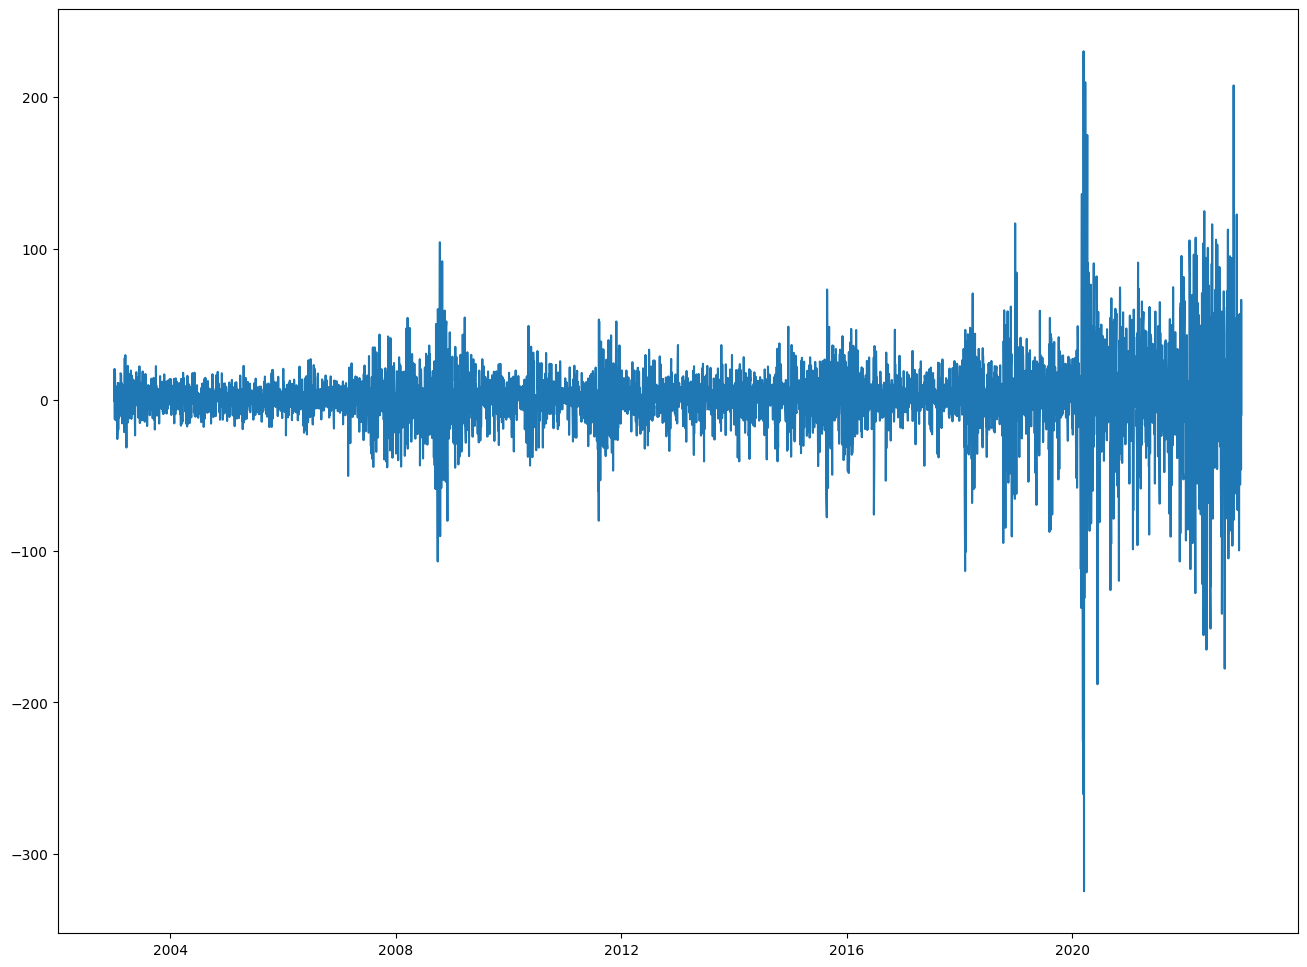

In [6]:
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(data)

## Offline Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

In [67]:
from bayesian_changepoint_detection.priors import const_prior, geom_prior, negative_binomial_prior
from functools import partial

prior_function = partial(const_prior)

In [77]:
# Q_, P_, Pcp_
# Q__, P__, Pcp__
Q, P, Pcp

(array([-2.13825915e+04, -2.13792192e+04, -2.13758574e+04, ...,
        -2.06581546e+01, -1.49091695e+01, -6.03927515e+00]),
 array([[-1.71689913e+00, -1.11017015e+01, -1.49809321e+01, ...,
                    -inf,            -inf, -2.34933381e+04],
        [           -inf, -7.89986573e+00, -1.18091051e+01, ...,
                    -inf,            -inf, -2.34891732e+04],
        [           -inf,            -inf, -8.37306420e+00, ...,
                    -inf,            -inf, -2.34850073e+04],
        ...,
        [           -inf,            -inf,            -inf, ...,
         -1.12684933e+01, -1.60700769e+01, -2.06578047e+01],
        [           -inf,            -inf,            -inf, ...,
                    -inf, -1.04751765e+01, -1.49090108e+01],
        [           -inf,            -inf,            -inf, ...,
                    -inf,            -inf, -6.03927515e+00]]),
 array([[           -inf, -1.28920483e+01, -1.18298735e+01, ...,
                    -inf,            -i

In [71]:
data[0] = 0

In [73]:
from scipy import stats

params = stats.t.fit(data)
params.

(1.7662253422201926, 1.210188573388813, 10.351056075803037)

In [75]:
data

Date
2003-01-02     0.000000
2003-01-03    -0.440002
2003-01-06    20.419983
2003-01-07    -6.080017
2003-01-08   -13.000000
                ...    
2022-12-23    22.430176
2022-12-27   -15.570068
2022-12-28   -46.030029
2022-12-29    66.060059
2022-12-30    -9.780029
Name: Close, Length: 5035, dtype: float64

In [76]:
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)

c:\Users\tiesh\Documents\Thesis_CD\DyART\Combined_code\bayesian_changepoint_detection\bayesian_models.py:68: RuntimeWarning: invalid value encountered in log
  antiG = np.log(-G[n - 1 - t])
c:\Users\tiesh\Documents\Thesis_CD\DyART\Combined_code\bayesian_changepoint_detection\bayesian_models.py:70: RuntimeWarning: invalid value encountered in logaddexp
  Q[t] = np.logaddexp(P_next_cp, P[t, n - 1] + antiG)
c:\Users\tiesh\Documents\Thesis_CD\DyART\Combined_code\bayesian_changepoint_detection\bayesian_models.py:54: RuntimeWarning: invalid value encountered in logaddexp
  P_next_cp = np.logaddexp(P_next_cp, summand)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=False)
ax[0].plot(data[:])
ax[1].plot(np.exp(Pcp).sum(0))

The `offline_changepoint_detection()` function returns three things: `Q[t]`, the log-likelihood of data `[t, n]`, `P[t, s]`, the log-likelihood of a datasequence `[t, s]`, given there is no changepoint between `t` and `s` and `Pcp[i, t]`, the log-likelihood that the `i`-th changepoint is at time step `t`. To actually get the probility of a changepoint at time step `t` sum the probabilities.

How does that look like for our toy-data?

In [35]:
data.shape

(5035,)

In [65]:
Pcp

array([[           -inf, -1.28920483e+01, -1.18298735e+01, ...,
                   -inf,            -inf,            -inf],
       [           -inf,            -inf, -2.48478756e+01, ...,
                   -inf,            -inf,            -inf],
       [           -inf,            -inf,            -inf, ...,
                   -inf,            -inf,            -inf],
       ...,
       [           -inf,            -inf,            -inf, ...,
                   -inf, -5.78349258e+04, -5.78248086e+04],
       [           -inf,            -inf,            -inf, ...,
                   -inf,            -inf, -5.78450547e+04],
       [           -inf,            -inf,            -inf, ...,
                   -inf,            -inf,            -inf]])

C:\Users\tiesh\AppData\Local\Temp\ipykernel_23796\3974719184.py:8: RuntimeWarning: invalid value encountered in log
  density_matrix = -np.log(Pcp[0:-1:sparsity, 0:-1:sparsity]+epsilon)


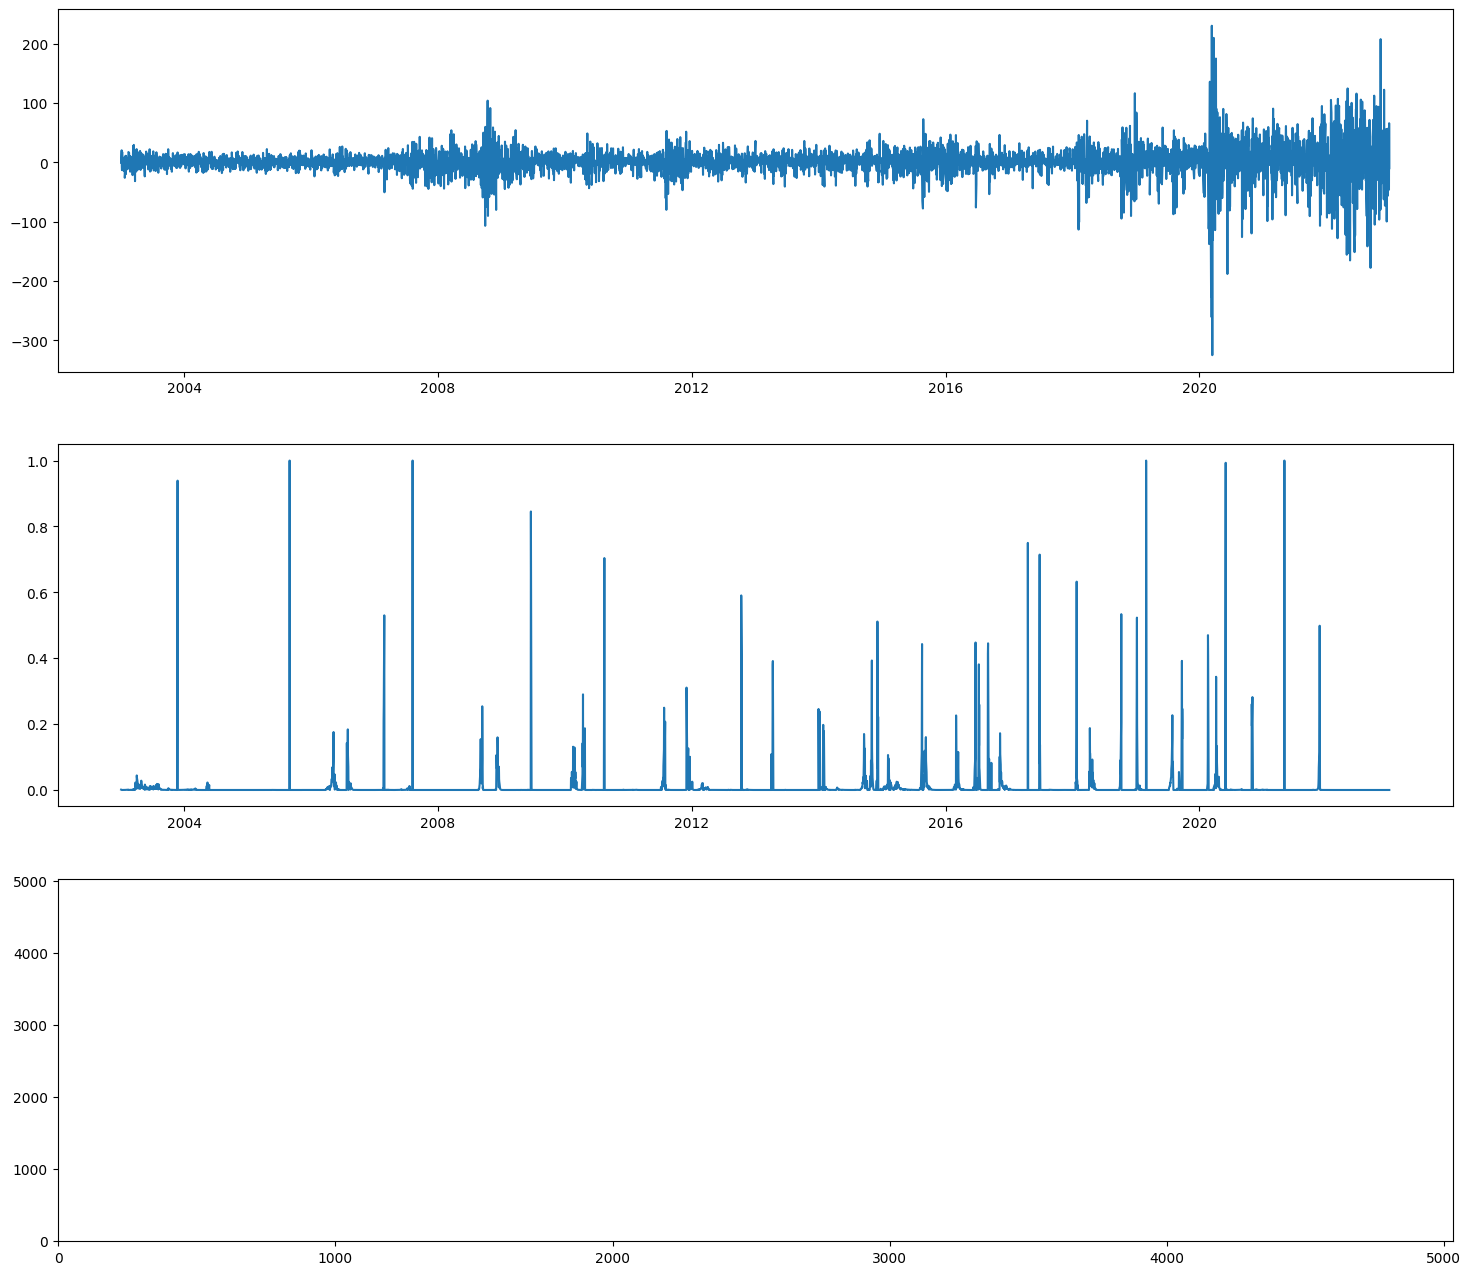

In [60]:
import matplotlib.cm as cm
changepoints = pd.DataFrame(np.exp(Pcp_).sum(0))
changepoints.index = data.index[1:]
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=False)
ax[0].plot(data[:])
ax[1].plot(changepoints)
sparsity=5
density_matrix = -np.log(Pcp_[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[2].pcolor(np.array(range(0, len(Pcp_[:,0]), sparsity)), 
          np.array(range(0, len(Pcp_[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')

In [48]:
for i, x in enumerate(np.array(changepoints)):
    # print(i,x)
    if x > 0.8:
        print(changepoints.index[i], x)

2003-11-24 00:00:00 [0.93902666]
2005-08-30 00:00:00 [0.99999569]
2007-08-08 00:00:00 [0.99999738]
2009-06-19 00:00:00 [0.84543228]
2019-03-01 00:00:00 [0.99996706]
2020-06-01 00:00:00 [0.9932705]
2021-05-05 00:00:00 [0.99999229]


In [43]:
changepoints.to_excel("changepoints.xlsx")

In [44]:
max(changepoints)

0

That works pretty well, but is somewhat slow. It's possible to speed that up by truncating a sum in the algorithm. However that sometimes leeds to $\infty$ values. Set the `truncate` parameter to e.g. `-10` to test that out.

To understand, what is happening have a look at the following papers:

[1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple
Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213

[2] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in
Multivariate Time Series, ICML (2007), pp. 1055--1062
                                                                                                                                                                                          

## Online Changepoint Detection

Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

Happily there is one, although it's interface is kind of suboptimal so far, in that it expects batches of data still and just assumes they drop in over time... I will change that at some point.

In [10]:
from bayesian_changepoint_detection.hazard_functions import constant_hazard
hazard_function = partial(constant_hazard, 250)

In [58]:
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll

R, maxes = online_changepoint_detection(
    data, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. `R[7, 3]` is the probability at time step `7` that the last sequence is already `3` time steps long. It also returns the MAP estimate at each timestep for convenience.

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

Because it's very hard to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for `Nw` samples and evalute the probability of a change happening `Nw` samples prior.

In [13]:
import pandas as pd
from pandas.tseries.offsets import BDay

# Assuming dt_index is your existing DatetimeIndex
print(data.index)
last_date = data.index[-1]
next_business_day = last_date + BDay(1)
new_index = data.index.append(pd.DatetimeIndex([next_business_day]))
new_index.values

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=5035, freq=None)


array(['2003-01-02T00:00:00.000000000', '2003-01-03T00:00:00.000000000',
       '2003-01-06T00:00:00.000000000', ...,
       '2022-12-29T00:00:00.000000000', '2022-12-30T00:00:00.000000000',
       '2023-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
import pandas as pd 
new_R = pd.DataFrame(data = R)
new_R.index = new_index

In [81]:
R

array([[1.00000000e+00, 4.00000000e-03, 4.00000000e-03, ...,
        4.00000000e-03, 4.00000000e-03, 4.00000000e-03],
       [0.00000000e+00, 9.96000000e-01, 2.67536328e-03, ...,
        5.08193621e-04, 4.90990422e-04, 2.55517332e-03],
       [0.00000000e+00, 0.00000000e+00, 9.93324637e-01, ...,
        6.93805385e-04, 1.87742050e-04, 2.92167107e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

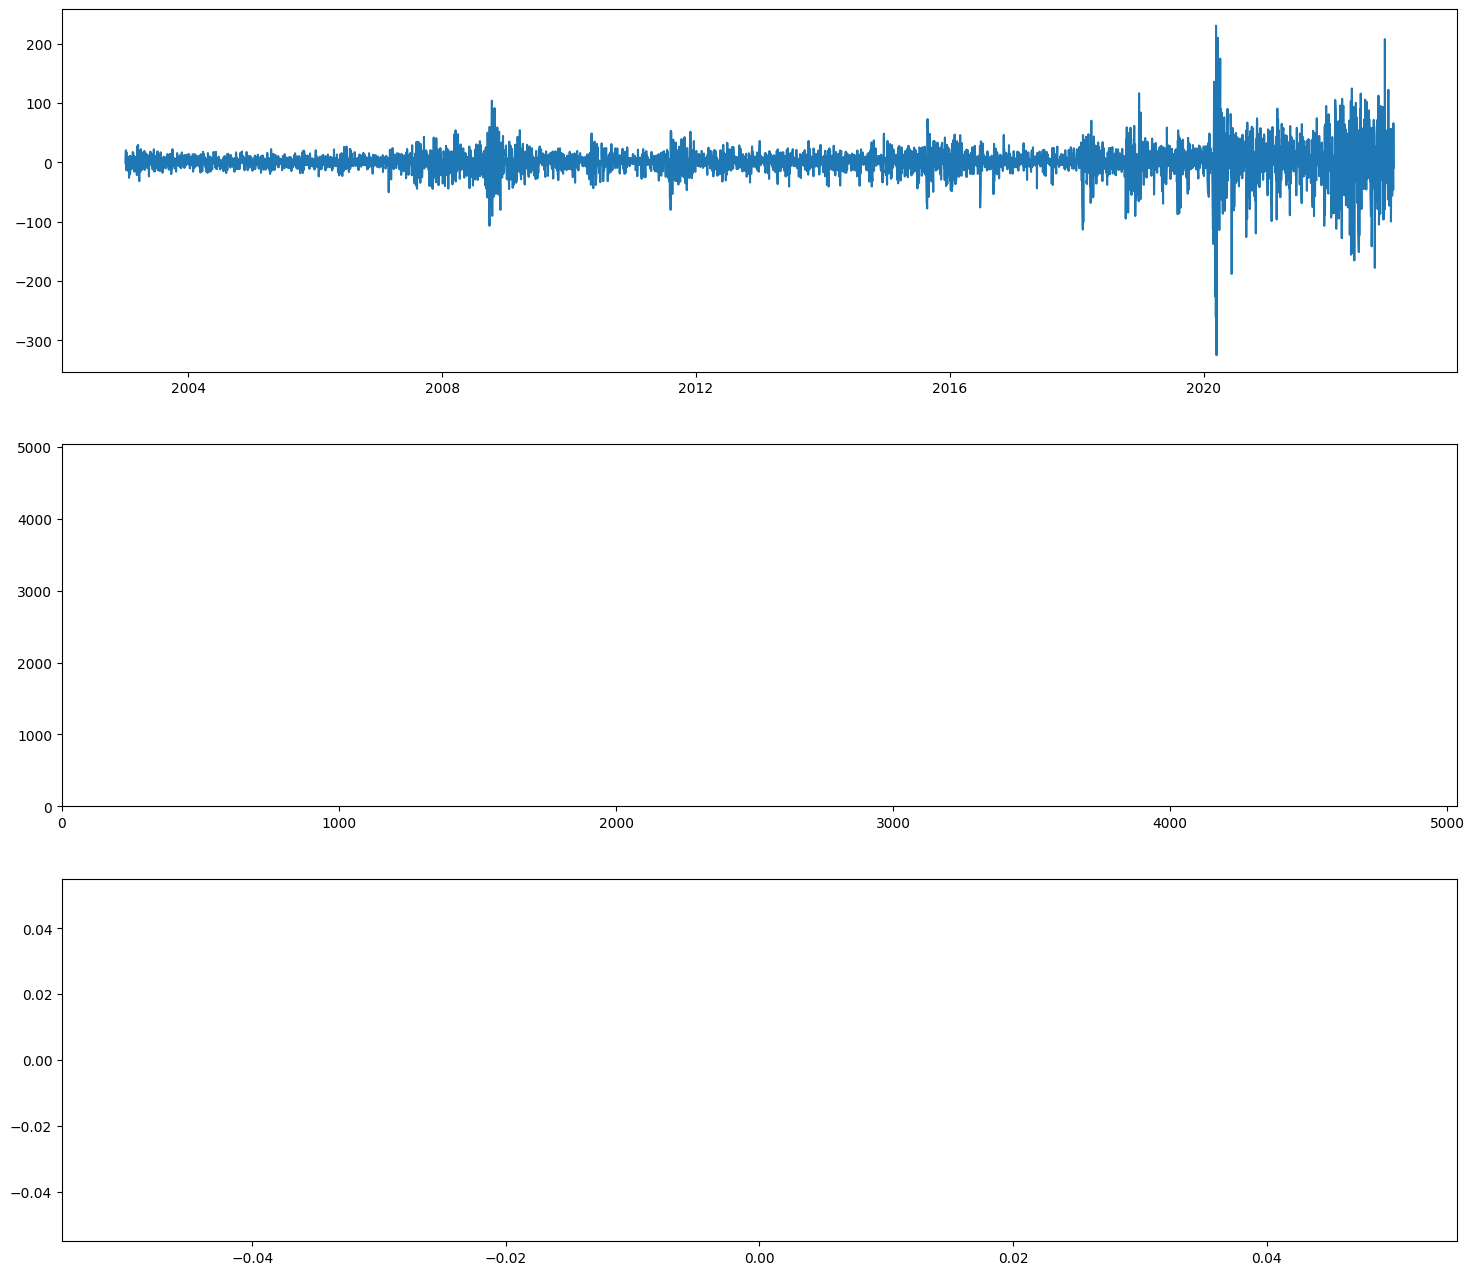

In [59]:
import matplotlib.cm as cm
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=False)
ax[0].plot(data)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[2].plot(R[Nw,Nw:-1])

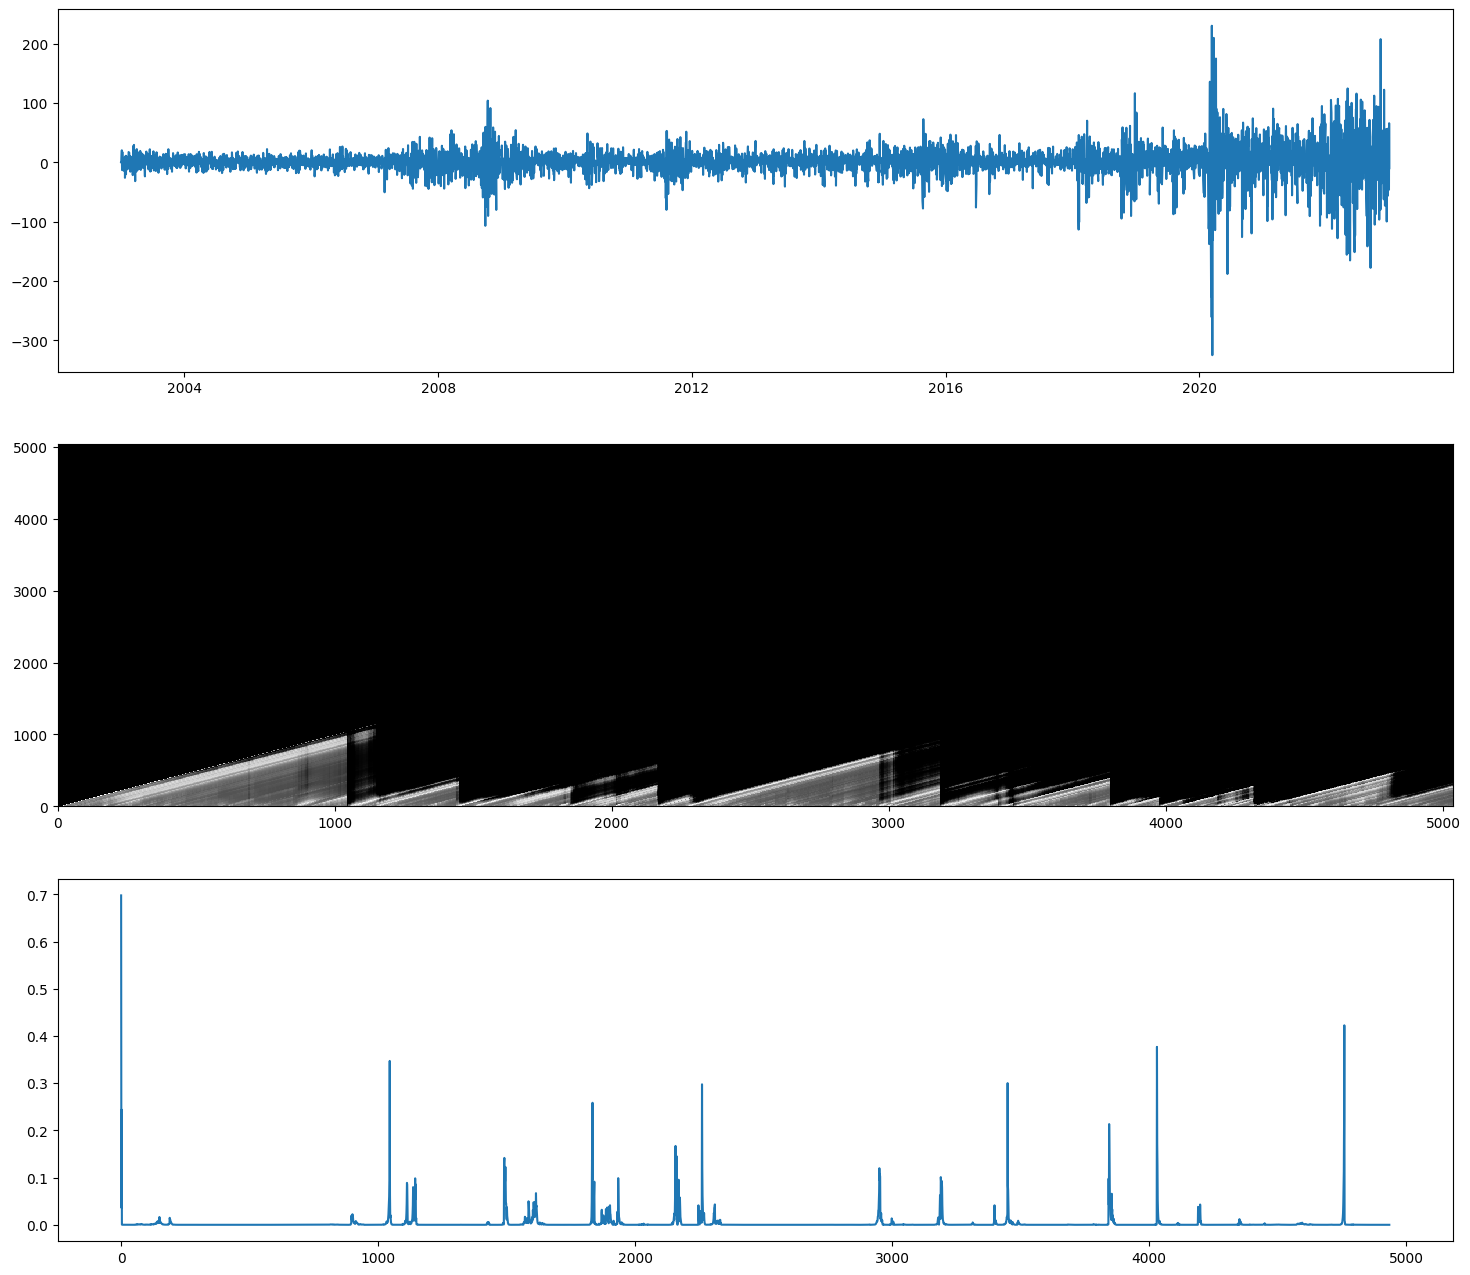

In [80]:
import matplotlib.cm as cm
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=False)
ax[0].plot(data)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
# ax[1].xticks = new_index.values
Nw=100
ax[2].plot(R[Nw,Nw:-1])

Well, not bad, considering how much faster it is (if you can afford waiting for that extra `Nw` samples). To understand the whole algorithm look at

[1] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection,
arXiv 0710.3742 (2007)

There you also find a Matlab version, which this code is based on.

In [10]:
partition, data = generate_normal_time_series(7, 50, 200)

In [ ]:
%timeit Q, P, Pcp = offline_changepoint_detection(data, prior_function, offline_ll.StudentT(), truncate=-40)

In [108]:
%timeit R, maxes = online_changepoint_detection(data, hazard_function, online_ll.StudentT(10, .03, 1, 0))

8.2 s ± 614 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
# def online_changepoint_detection(data, hazard_function, log_likelihood_class):
"""
Use online bayesian changepoint detection
https://scientya.com/bayesian-online-change-point-detection-an-intuitive-understanding-b2d2b9dc165b

Parameters:
data    -- the time series data

Outputs:
    R  -- is the probability at time step t that the last sequence is already s time steps long
    maxes -- the argmax on column axis of matrix R (growth probability value) for each time step
"""
log_likelihood_class = online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
maxes = np.zeros(len(data) + 1)

R = np.zeros((len(data) + 1, len(data) + 1))
R[0, 0] = 1

for t, x in enumerate(data):
    # Evaluate the predictive distribution for the new datum under each of
    # the parameters.  This is the standard thing from Bayesian inference.
    predprobs = log_likelihood_class.pdf(x)

    # Evaluate the hazard function for this interval
    H = hazard_function(np.array(range(t + 1)))

    # Evaluate the growth probabilities - shift the probabilities down and to
    # the right, scaled by the hazard function and the predictive
    # probabilities.
    R[1 : t + 2, t + 1] = R[0 : t + 1, t] * predprobs * (1 - H)

    # Evaluate the probability that there *was* a changepoint and we're
    # accumulating the mass back down at r = 0.
    R[0, t + 1] = np.sum(R[0 : t + 1, t] * predprobs * H)

    # Renormalize the run length probabilities for improved numerical
    # stability.
    R[:, t + 1] = R[:, t + 1] / np.sum(R[:, t + 1])

    # Update the parameter sets for each possible run length.
    log_likelihood_class.update_theta(x, t=t)

    maxes[t] = R[:, t].argmax()

    # return R, maxes

In [79]:
R

array([[1.00000000e+00, 4.00000000e-03, 4.00000000e-03, ...,
        4.00000000e-03, 4.00000000e-03, 4.00000000e-03],
       [0.00000000e+00, 9.96000000e-01, 2.67536328e-03, ...,
        5.08193621e-04, 4.90990422e-04, 2.55517332e-03],
       [0.00000000e+00, 0.00000000e+00, 9.93324637e-01, ...,
        6.93805385e-04, 1.87742050e-04, 2.92167107e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])